#About the dataset:
  
  - The dataset can be downloaded from : [ShanghaiTech_Crowd_Counting_Dataset](https://drive.google.com/file/d/16dhJn7k4FWVwByRsQAEpl9lwjuV03jVI/view)
  - I uploaded the dataset onto Google drive & mounted the drive into the google colab notebook.

#Importing necessary Libraries

In [22]:
import os
import cv2
import glob
import h5py
import math
import scipy
import random
import numpy as np
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
from keras.layers import AveragePooling2D


def get_density_map_gaussian(im, points, adaptive_mode=False, fixed_value=15, fixed_values=None):
    density_map = np.zeros(im.shape[:2], dtype=np.float32)
    h, w = density_map.shape[:2]
    num_gt = np.squeeze(points).shape[0]
    if num_gt == 0:
        return density_map

    if adaptive_mode == True:
        fixed_values = None
        leafsize = 2048
        tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
        distances, locations = tree.query(points, k=4)
    for idx, p in enumerate(points):
        p = np.round(p).astype(int)
        p[0], p[1] = min(h-1, p[1]), min(w-1, p[0])
        if num_gt > 1:
            if adaptive_mode == 1:
                sigma = int(np.sum(distances[idx][1:4]) * 0.1)
            elif adaptive_mode == 0:
                sigma = fixed_value
        else:
            sigma = fixed_value
        sigma = max(1, sigma)
        gaussian_radius_no_detection = sigma * 3
        gaussian_radius = gaussian_radius_no_detection

        if fixed_values is not None:
            grid_y, grid_x = int(p[0]//(h/3)), int(p[1]//(w/3))
            grid_idx = grid_y * 3 + grid_x
            gaussian_radius = fixed_values[grid_idx] if fixed_values[grid_idx] else gaussian_radius_no_detection
        gaussian_map = np.multiply(
            cv2.getGaussianKernel(gaussian_radius*2+1, sigma),
            cv2.getGaussianKernel(gaussian_radius*2+1, sigma).T
        )
        gaussian_map[gaussian_map < 0.0003] = 0
        if np.sum(gaussian_map):
            gaussian_map = gaussian_map / np.sum(gaussian_map)
        x_left, x_right, y_up, y_down = 0, gaussian_map.shape[1], 0, gaussian_map.shape[0]
        # cut the gaussian kernel
        if p[1] < gaussian_radius:
            x_left = gaussian_radius - p[1]
        if p[0] < gaussian_radius:
            y_up = gaussian_radius - p[0]
        if p[1] + gaussian_radius >= w:
            x_right = gaussian_map.shape[1] - (gaussian_radius + p[1] - w) - 1
        if p[0] + gaussian_radius >= h:
            y_down = gaussian_map.shape[0] - (gaussian_radius + p[0] - h) - 1
        density_map[
            max(0, p[0]-gaussian_radius):min(density_map.shape[0], p[0]+gaussian_radius+1),
            max(0, p[1]-gaussian_radius):min(density_map.shape[1], p[1]+gaussian_radius+1)
        ] += gaussian_map[y_up:y_down, x_left:x_right]
    density_map = density_map / (np.sum(density_map / num_gt))
    return density_map





In [23]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


with_direction = False

In [24]:
root = '/content/drive/MyDrive/part_A_final'

In [25]:
part_A_train = os.path.join(root, '/content/drive/MyDrive/part_A_final/train_data', 'images') #Path for training dataset
part_A_test = os.path.join(root, '/content/drive/MyDrive/part_A_final/test_data', 'images') #Path for testing dataset.

path_sets_A = [part_A_train, part_A_test]

In [26]:
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))



482


In [27]:
#Providing the path for the image for visualization.

img_paths = ['/content/drive/MyDrive/part_A_final/train_data/images/IMG_143.jpg',
             '/content/drive/MyDrive/part_A_final/train_data/images/IMG_156.jpg']

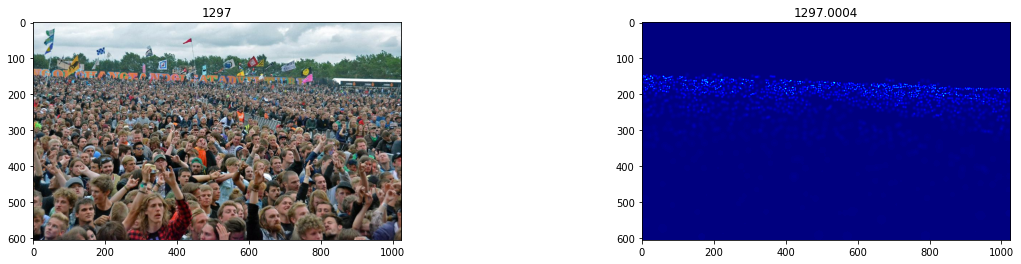

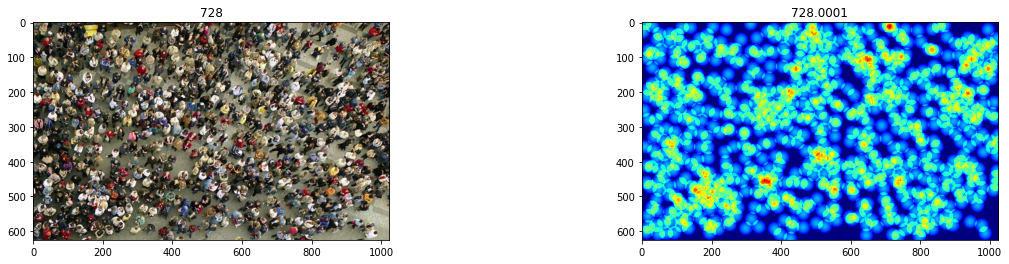

In [28]:
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground_truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(k), cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()

So by this technique we can basically predict number of persons in a crowded picture.